# Lab 3 - Reconstruction Decoder (Notebook Runner)

This notebook is configured to run Lab 3 end-to-end from top to bottom:

1. Configure run variables (single config cell).
2. Launch staged training (`stage1` then `stage2`) using `run_lab3.py`.
3. Load audit outputs.
4. Generate qualitative samples (mel plots + WAV files) for direct inspection.

Use `RUN_MODE='fresh'` for a new run or `RUN_MODE='resume'` to continue an existing run.


In [1]:
from pathlib import Path
import json
import shutil
import subprocess
import os

import numpy as np
import pandas as pd
import torch
import librosa
import matplotlib.pyplot as plt

try:
    import soundfile as sf
    HAS_SF = True
except Exception:
    HAS_SF = False

from IPython.display import Audio, display

from src.lab3_data import load_cache, stratified_split_indices
from src.lab3_models import ReconstructionDecoder
from src.lab3_bridge import FrozenLab1Encoder, denormalize_log_mel
from src.lab3_train import load_target_centroids, build_condition_bank
import importlib

# torch sanity guard for notebook kernels with partially initialized modules
if not hasattr(torch, '_utils'):
    torch._utils = importlib.import_module('torch._utils')
print('torch:', torch.__version__, 'file:', torch.__file__)



torch: 2.10.0+cu128 file: Z:\328\CMPUT328-A2\codexworks\301\414-pl1\.venv_lab1\Lib\site-packages\torch\__init__.py


## Run Config

Set everything here, then run all cells.


In [2]:
# -----------------------------
# Core run controls
# -----------------------------
REPO_ROOT = Path.cwd().parent
LAB3_DIR = Path.cwd()
SAVES_ROOT = REPO_ROOT / 'saves' / 'lab3_synthesis'

def find_latest_run_dir(saves_root: Path):
    candidates = []
    for d in saves_root.iterdir() if saves_root.exists() else []:
        if not d.is_dir():
            continue
        rs = d / 'run_state.json'
        if rs.exists():
            candidates.append(d)
    if not candidates:
        return None
    return max(candidates, key=lambda p: (p / 'run_state.json').stat().st_mtime)

RUN_MODE = 'fresh'
RUN_NAME = 'automatedruns2'
RESUME_DIR = SAVES_ROOT / 'auto_q2_divfix_m18'  # best current run
CLEAN_START = False          # if fresh and run folder exists, delete it first

# Optional cache reuse (speeds up iteration)
REUSE_CACHE_DIR = SAVES_ROOT / 'run_2' / 'cache'

# -----------------------------
# Data/model paths
# -----------------------------
MANIFESTS_ROOT = Path('Z:/DataSets/_lab1_manifests')
LAB1_CHECKPOINT = REPO_ROOT / 'saves' / 'lab1_run_combo_af_gate_exit_v2' / 'latest.pt'
LAB2_TARGET_CENTROIDS = REPO_ROOT / 'saves' / 'lab2_calibration' / 'lab2_20260211_015118_lda_cleanup_v2' / 'target_centroids.json'

# -----------------------------
# Training scale
# -----------------------------
SMOKE = False
PER_GENRE_SAMPLES = 800
VAL_RATIO = 0.15
N_FRAMES = 256
BATCH_SIZE = 32
NUM_WORKERS = 0
SEED = 328
DEVICE = 'auto'              # 'auto' | 'cuda' | 'cpu'
GENERATOR_NORM = 'instance'  # 'instance' | 'batch'
GENERATOR_UPSAMPLE = 'pixelshuffle'  # 'transpose' | 'pixelshuffle'
DISCRIMINATOR_ARCH = 'multiscale'   # 'single' | 'multiscale'
DISCRIMINATOR_SCALES = 3

STAGE1_EPOCHS = 2
STAGE2_EPOCHS = 20
MAX_BATCHES_PER_EPOCH = 40

# -----------------------------
# Loss weights
# -----------------------------
LR_G = 2e-4
LR_D = 5e-5
ADV_WEIGHT = 0.8
RECON_WEIGHT = 5.0
CONTENT_WEIGHT = 3.0
STYLE_WEIGHT = 12.0
CONTINUITY_WEIGHT = 1.0
FLATNESS_WEIGHT = 0.2
FEATURE_MATCH_WEIGHT = 1.0
PERCEPTUAL_WEIGHT = 0.7
STYLE_HINGE_WEIGHT = 2.0
CONTRASTIVE_WEIGHT = 5.5
DIVERSITY_WEIGHT = 2.0
TIMBRE_BALANCE_WEIGHT = 2.5
LOWMID_RECON_WEIGHT = 1.8
SPECTRAL_TILT_WEIGHT = 2.6
ZCR_PROXY_WEIGHT = 0.8
STYLE_MID_WEIGHT = 3.0
HF_MUZZLE_WEIGHT = 2.4
HIGHPASS_ANCHOR_WEIGHT = 0.6
MEL_DIVERSITY_WEIGHT = 4.0
TARGET_PROFILE_WEIGHT = 28.0
STAGE2_D_LR_MULT = 1.0
STAGE2_CONTENT_START = 0.18
STAGE2_CONTENT_END = 0.18
STAGE2_STYLE_LABEL_SMOOTHING = 0.1
STAGE2_STYLE_ONLY_WARMUP_EPOCHS = 0
STAGE2_G_LR_WARMUP_EPOCHS = 0
STAGE2_G_LR_START_MULT = 1.0
STAGE2_COND_NOISE_STD = 0.10
STAGE2_STYLE_JITTER_STD = 0.10
STAGE2_STYLE_HINGE_TARGET_CONF = 0.55
STAGE2_ADAPTIVE_CONTENT = False
STAGE2_ADAPTIVE_CONTENT_LOW = 0.0
STAGE2_ADAPTIVE_CONTENT_HIGH = 0.4
STAGE2_ADAPTIVE_CONF_LOW = 0.30
STAGE2_ADAPTIVE_CONF_HIGH = 0.45
STAGE2_STYLE_CRITIC_LR = 2e-4
STAGE2_CONTRASTIVE_TEMP = 0.10
STAGE2_DIVERSITY_MARGIN = 0.90
STAGE2_DIVERSITY_MAX_PAIRS = 128
STAGE2_MEL_DIVERSITY_MARGIN = 0.60
STAGE2_MEL_DIVERSITY_MAX_PAIRS = 192
STAGE2_STYLE_LOWPASS_KEEP_BINS = 80
STAGE2_STYLE_LOWPASS_CUTOFF_HZ = 4300.0
STAGE2_STYLE_MID_LOW_BIN = 8
STAGE2_STYLE_MID_HIGH_BIN = 56
STAGE2_LOWMID_SPLIT_BIN = 80
STAGE2_LOWMID_GAIN = 7.0
STAGE2_HIGH_GAIN = 0.45
STAGE2_SPECTRAL_TILT_MAX_RATIO = 0.78
STAGE2_ZCR_PROXY_TARGET_MAX = 0.20
RESET_STAGE2_OUT_LAYER = False
D_REAL_LABEL = 0.7
D_FAKE_LABEL = 0.3
G_REAL_LABEL = 0.7

# -----------------------------
# Exit thresholds
# -----------------------------
MPS_THRESHOLD = 0.90
SF_THRESHOLD = 0.85
EVAL_MAX_BATCHES = 30

# -----------------------------
# Generation preview settings
# -----------------------------
N_GENERATION_SAMPLES = 6
TARGET_GENRE_ORDER = ['baroque_classical', 'hiphop_xtc', 'lofi_hh_lfbb', 'cc0_other']
GL_ITERS = 64

if RUN_MODE == 'fresh':
    OUT_DIR = SAVES_ROOT / RUN_NAME if RUN_NAME else SAVES_ROOT
elif RUN_MODE == 'resume':
    if RESUME_DIR is None:
        raise ValueError("RUN_MODE='resume' requires RESUME_DIR")
    OUT_DIR = Path(RESUME_DIR)
else:
    raise ValueError("RUN_MODE must be 'fresh' or 'resume'")

OUT_DIR









WindowsPath('Z:/328/CMPUT328-A2/codexworks/301/414-pl1/saves/lab3_synthesis/automatedruns2')

In [3]:
# Prepare run directory (fresh mode cleanup)
if RUN_MODE == 'fresh' and RUN_NAME == '':
    print('[setup] RUN_NAME empty: training will auto-create numbered run directories (run_1, run_2, ...).')

if RUN_MODE == 'fresh' and CLEAN_START and RUN_NAME and OUT_DIR.exists():
    print(f'[setup] removing existing run dir: {OUT_DIR}')
    shutil.rmtree(OUT_DIR)

if RUN_MODE == 'resume':
    OUT_DIR.mkdir(parents=True, exist_ok=True)

print('[setup] target run_dir =', OUT_DIR)



[setup] target run_dir = Z:\328\CMPUT328-A2\codexworks\301\414-pl1\saves\lab3_synthesis\automatedruns2


## Launch Training Pipeline

This calls `run_lab3.py` with the config above.


In [4]:
cmd = [
    'python', 'run_lab3.py',
    '--mode', RUN_MODE,
    '--manifests-root', str(MANIFESTS_ROOT),
    '--lab1-checkpoint', str(LAB1_CHECKPOINT),
    '--lab2-centroids-json', str(LAB2_TARGET_CENTROIDS),
    '--per-genre-samples', str(PER_GENRE_SAMPLES),
    '--seed', str(SEED),
    '--val-ratio', str(VAL_RATIO),
    '--n-frames', str(N_FRAMES),
    '--batch-size', str(BATCH_SIZE),
    '--num-workers', str(NUM_WORKERS),
    '--generator-norm', str(GENERATOR_NORM),
    '--generator-upsample', str(GENERATOR_UPSAMPLE),
    '--discriminator-arch', str(DISCRIMINATOR_ARCH),
    '--discriminator-scales', str(DISCRIMINATOR_SCALES),
    '--stage1-epochs', str(STAGE1_EPOCHS),
    '--stage2-epochs', str(STAGE2_EPOCHS),
    '--lr-g', str(LR_G),
    '--lr-d', str(LR_D),
    '--adv-weight', str(ADV_WEIGHT),
    '--recon-weight', str(RECON_WEIGHT),
    '--content-weight', str(CONTENT_WEIGHT),
    '--style-weight', str(STYLE_WEIGHT),
    '--continuity-weight', str(CONTINUITY_WEIGHT),
    '--flatness-weight', str(FLATNESS_WEIGHT),
    '--feature-match-weight', str(FEATURE_MATCH_WEIGHT),
    '--perceptual-weight', str(PERCEPTUAL_WEIGHT),
    '--style-hinge-weight', str(STYLE_HINGE_WEIGHT),
    '--contrastive-weight', str(CONTRASTIVE_WEIGHT),
    '--diversity-weight', str(DIVERSITY_WEIGHT),
    '--timbre-balance-weight', str(TIMBRE_BALANCE_WEIGHT),
    '--lowmid-recon-weight', str(LOWMID_RECON_WEIGHT),
    '--spectral-tilt-weight', str(SPECTRAL_TILT_WEIGHT),
    '--zcr-proxy-weight', str(ZCR_PROXY_WEIGHT),
    '--style-mid-weight', str(STYLE_MID_WEIGHT),
    '--hf-muzzle-weight', str(HF_MUZZLE_WEIGHT),
    '--highpass-anchor-weight', str(HIGHPASS_ANCHOR_WEIGHT),
    '--mel-diversity-weight', str(MEL_DIVERSITY_WEIGHT),
    '--target-profile-weight', str(TARGET_PROFILE_WEIGHT),
    '--stage2-d-lr-mult', str(STAGE2_D_LR_MULT),
    '--stage2-content-start', str(STAGE2_CONTENT_START),
    '--stage2-content-end', str(STAGE2_CONTENT_END),
    '--stage2-style-label-smoothing', str(STAGE2_STYLE_LABEL_SMOOTHING),
    '--stage2-style-only-warmup-epochs', str(STAGE2_STYLE_ONLY_WARMUP_EPOCHS),
    '--stage2-g-lr-warmup-epochs', str(STAGE2_G_LR_WARMUP_EPOCHS),
    '--stage2-g-lr-start-mult', str(STAGE2_G_LR_START_MULT),
    '--stage2-cond-noise-std', str(STAGE2_COND_NOISE_STD),
    '--stage2-style-jitter-std', str(STAGE2_STYLE_JITTER_STD),
    '--stage2-style-hinge-target-conf', str(STAGE2_STYLE_HINGE_TARGET_CONF),
    '--stage2-adaptive-content-low', str(STAGE2_ADAPTIVE_CONTENT_LOW),
    '--stage2-adaptive-content-high', str(STAGE2_ADAPTIVE_CONTENT_HIGH),
    '--stage2-adaptive-conf-low', str(STAGE2_ADAPTIVE_CONF_LOW),
    '--stage2-adaptive-conf-high', str(STAGE2_ADAPTIVE_CONF_HIGH),
    '--stage2-style-critic-lr', str(STAGE2_STYLE_CRITIC_LR),
    '--stage2-contrastive-temp', str(STAGE2_CONTRASTIVE_TEMP),
    '--stage2-diversity-margin', str(STAGE2_DIVERSITY_MARGIN),
    '--stage2-diversity-max-pairs', str(STAGE2_DIVERSITY_MAX_PAIRS),
    '--stage2-mel-diversity-margin', str(STAGE2_MEL_DIVERSITY_MARGIN),
    '--stage2-mel-diversity-max-pairs', str(STAGE2_MEL_DIVERSITY_MAX_PAIRS),
    '--stage2-style-lowpass-keep-bins', str(STAGE2_STYLE_LOWPASS_KEEP_BINS),
    '--stage2-style-lowpass-cutoff-hz', str(STAGE2_STYLE_LOWPASS_CUTOFF_HZ),
    '--stage2-style-mid-low-bin', str(STAGE2_STYLE_MID_LOW_BIN),
    '--stage2-style-mid-high-bin', str(STAGE2_STYLE_MID_HIGH_BIN),
    '--stage2-lowmid-split-bin', str(STAGE2_LOWMID_SPLIT_BIN),
    '--stage2-lowmid-gain', str(STAGE2_LOWMID_GAIN),
    '--stage2-high-gain', str(STAGE2_HIGH_GAIN),
    '--stage2-spectral-tilt-max-ratio', str(STAGE2_SPECTRAL_TILT_MAX_RATIO),
    '--stage2-zcr-proxy-target-max', str(STAGE2_ZCR_PROXY_TARGET_MAX),
    '--mps-threshold', str(MPS_THRESHOLD),
    '--sf-threshold', str(SF_THRESHOLD),
    '--eval-max-batches', str(EVAL_MAX_BATCHES),
    '--device', str(DEVICE),
    '--d-real-label', str(D_REAL_LABEL),
    '--d-fake-label', str(D_FAKE_LABEL),
    '--g-real-label', str(G_REAL_LABEL),
]

if RUN_MODE == 'fresh':
    cmd.extend(['--run-name', RUN_NAME])
if RUN_MODE == 'resume':
    cmd.extend(['--resume-dir', str(OUT_DIR)])
if REUSE_CACHE_DIR is not None:
    cmd.extend(['--reuse-cache-dir', str(REUSE_CACHE_DIR)])
if MAX_BATCHES_PER_EPOCH is not None:
    cmd.extend(['--max-batches-per-epoch', str(MAX_BATCHES_PER_EPOCH)])
if SMOKE:
    cmd.append('--smoke')
if STAGE2_ADAPTIVE_CONTENT:
    cmd.append('--stage2-adaptive-content')
if RESET_STAGE2_OUT_LAYER:
    cmd.append('--reset-stage2-out-layer')

print(' '.join(cmd))

# Stream training logs directly to notebook output
p = subprocess.Popen(
    cmd,
    cwd=str(LAB3_DIR),
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1,
)
for line in p.stdout:
    print(line, end='')
ret = p.wait()
if ret != 0:
    raise subprocess.CalledProcessError(ret, cmd)

# In fresh auto-run mode, resolve OUT_DIR to the created run_N folder.
if RUN_MODE == 'fresh' and RUN_NAME == '':
    latest = find_latest_run_dir(SAVES_ROOT)
    if latest is None:
        raise FileNotFoundError('No run directory with run_state.json found under SAVES_ROOT after training.')
    OUT_DIR = latest
    print(f'[post-run] resolved run_dir = {OUT_DIR}')







python run_lab3.py --mode fresh --manifests-root Z:\DataSets\_lab1_manifests --lab1-checkpoint Z:\328\CMPUT328-A2\codexworks\301\414-pl1\saves\lab1_run_combo_af_gate_exit_v2\latest.pt --lab2-centroids-json Z:\328\CMPUT328-A2\codexworks\301\414-pl1\saves\lab2_calibration\lab2_20260211_015118_lda_cleanup_v2\target_centroids.json --per-genre-samples 800 --seed 328 --val-ratio 0.15 --n-frames 256 --batch-size 32 --num-workers 0 --generator-norm instance --generator-upsample pixelshuffle --discriminator-arch multiscale --discriminator-scales 3 --stage1-epochs 2 --stage2-epochs 20 --lr-g 0.0002 --lr-d 5e-05 --adv-weight 0.8 --recon-weight 5.0 --content-weight 3.0 --style-weight 12.0 --continuity-weight 1.0 --flatness-weight 0.2 --feature-match-weight 1.0 --perceptual-weight 0.7 --style-hinge-weight 2.0 --contrastive-weight 5.5 --diversity-weight 2.0 --timbre-balance-weight 2.5 --lowmid-recon-weight 1.8 --spectral-tilt-weight 2.6 --zcr-proxy-weight 0.8 --style-mid-weight 3.0 --hf-muzzle-weigh

[lab3] reusing cache from Z:\328\CMPUT328-A2\codexworks\301\414-pl1\saves\lab3_synthesis\run_2\cache
[lab3] stage1 training...
[stage1] epoch=1 loss_g=8.6598 loss_d=0.6439
[stage1] epoch=2 loss_g=7.1911 loss_d=0.6184
[lab3] stage2 training...
[stage2] epoch=1 loss_g=38.6302 loss_d=0.6182
[stage2] epoch=2 loss_g=37.0752 loss_d=0.6217
[stage2] epoch=3 loss_g=36.1751 loss_d=0.6208
[stage2] epoch=4 loss_g=35.8403 loss_d=0.6195
[stage2] epoch=5 loss_g=35.3809 loss_d=0.6160
[stage2] epoch=6 loss_g=35.0625 loss_d=0.6166
[stage2] epoch=7 loss_g=34.7551 loss_d=0.6151
[stage2] epoch=8 loss_g=34.1429 loss_d=0.6129
[stage2] epoch=9 loss_g=33.6916 loss_d=0.6123
[stage2] epoch=10 loss_g=33.0612 loss_d=0.6126
[stage2] epoch=11 loss_g=32.3391 loss_d=0.6121
[stage2] epoch=12 loss_g=31.8388 loss_d=0.6117
[stage2] epoch=13 loss_g=30.8396 loss_d=0.6122
[stage2] epoch=14 loss_g=29.9351 loss_d=0.6117
[stage2] epoch=15 loss_g=29.4713 loss_d=0.6116
[stage2] epoch=16 loss_g=28.6634 loss_d=0.6118
[stage2] epoch

## Load Run Outputs


In [5]:
def resolve_run_dir_for_metrics(out_dir: Path, saves_root: Path, resume_dir: Path | None = None) -> Path:
    if (out_dir / 'run_state.json').exists():
        return out_dir

    if resume_dir is not None:
        resume_path = Path(resume_dir)
        if (resume_path / 'run_state.json').exists():
            return resume_path

    latest = find_latest_run_dir(saves_root)
    if latest is not None:
        print(f'[metrics] OUT_DIR has no run_state.json, using latest run dir: {latest}')
        return latest

    raise FileNotFoundError(
        f"No run_state.json found. Checked OUT_DIR={out_dir} and no run dirs under {saves_root}."
    )

OUT_DIR = resolve_run_dir_for_metrics(OUT_DIR, SAVES_ROOT, RESUME_DIR if RUN_MODE == 'resume' else None)
run_state_path = OUT_DIR / 'run_state.json'
audit_path = OUT_DIR / 'lab3_exit_audit.json'
history_path = OUT_DIR / 'history.csv'

run_state = json.loads(run_state_path.read_text(encoding='utf-8'))
audit = json.loads(audit_path.read_text(encoding='utf-8')) if audit_path.exists() else {}
history = pd.read_csv(history_path) if history_path.exists() else pd.DataFrame()

print('[resolved_out_dir]', OUT_DIR)
print('[run_state]')
print(json.dumps({
    'stage_cache_done': run_state.get('stage_cache_done'),
    'stage1_done': run_state.get('stage1_done'),
    'stage2_done': run_state.get('stage2_done'),
    'eval_done': run_state.get('eval_done'),
    'lab3_done': run_state.get('lab3_done'),
}, indent=2))

print('[audit]')
print(json.dumps(audit, indent=2))

history.tail(10)



[resolved_out_dir] Z:\328\CMPUT328-A2\codexworks\301\414-pl1\saves\lab3_synthesis\automatedruns2
[run_state]
{
  "stage_cache_done": true,
  "stage1_done": true,
  "stage2_done": true,
  "eval_done": true,
  "lab3_done": false
}
[audit]
{
  "n_eval": 422,
  "mps": 0.9640408158302307,
  "style_fidelity_conf": 0.649863064289093,
  "style_acc": 1.0,
  "spectral_continuity": 3.9454921739442006,
  "thresholds": {
    "mps": 0.9,
    "style_fidelity_conf": 0.85
  },
  "passes": {
    "mps": true,
    "style_fidelity": false,
    "spectral_continuity": true,
    "lab3_done": false
  },
  "classifier_quality": {
    "style_classifier_val_acc": 0.6966824644549763
  },
  "run_dir": "Z:\\328\\CMPUT328-A2\\codexworks\\301\\414-pl1\\saves\\lab3_synthesis\\automatedruns2"
}


,loss_g,loss_d,loss_adv,loss_l1,loss_content,loss_style,loss_continuity,stage,epoch,loss_sc,...,loss_hf_muzzle,loss_highpass_anchor,loss_feature_match,loss_perceptual,loss_diversity,loss_mel_diversity,loss_target_profile,content_weight,lr_g,style_conf
12,32.339065,0.612079,0.939054,NaN,0.041679,NaN,NaN,stage2,11,1.219550,...,0.005652,0.598830,0.348863,0.439593,0.023764,0.215998,0.005046,0.18,0.0002,0.317801
13,31.838835,0.611718,0.941676,NaN,0.045340,NaN,NaN,stage2,12,1.185606,...,0.004703,0.614184,0.352977,0.460348,0.025377,0.213572,0.005466,0.18,0.0002,0.333918
14,30.839582,0.612213,0.940820,NaN,0.044873,NaN,NaN,stage2,13,1.171033,...,0.005243,0.616397,0.352527,0.449305,0.024474,0.209255,0.005435,0.18,0.0002,0.359343
15,29.935102,0.611691,0.944260,NaN,0.047198,NaN,NaN,stage2,14,1.141594,...,0.005889,0.624246,0.355026,0.471144,0.024666,0.216336,0.005303,0.18,0.0002,0.383908
16,29.471304,0.611568,0.945692,NaN,0.045243,NaN,NaN,stage2,15,1.111154,...,0.005813,0.634740,0.356483,0.486425,0.024285,0.205896,0.005597,0.18,0.0002,0.398501
17,28.663389,0.611761,0.944050,NaN,0.045658,NaN,NaN,stage2,16,1.092292,...,0.005305,0.638123,0.355211,0.476787,0.025882,0.219308,0.005396,0.18,0.0002,0.421544
18,27.794087,0.611604,0.945184,NaN,0.045602,NaN,NaN,stage2,17,1.054637,...,0.005305,0.635423,0.356756,0.486142,0.027311,0.211098,0.005338,0.18,0.0002,0.448102
19,27.164907,0.611456,0.944888,NaN,0.046446,NaN,NaN,stage2,18,1.032688,...,0.005241,0.638532,0.354394,0.524229,0.023110,0.204144,0.005098,0.18,0.0002,0.472157
20,26.718772,0.611541,0.946715,NaN,0.047757,NaN,NaN,stage2,19,1.004908,...,0.005393,0.640543,0.351324,0.522317,0.025917,0.213890,0.005106,0.18,0.0002,0.490535
21,25.850113,0.611426,0.948113,NaN,0.049939,NaN,NaN,stage2,20,0.986655,...,0.005609,0.642032,0.353493,0.510995,0.027463,0.211208,0.005049,0.18,0.0002,0.521577


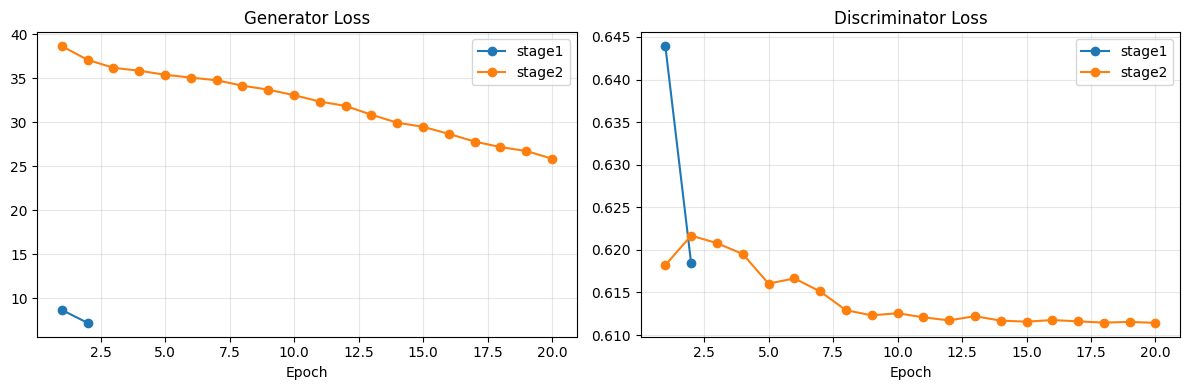

In [6]:
# Optional quick training curves
if len(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for stg, g in history.groupby('stage'):
        axes[0].plot(g['epoch'], g['loss_g'], marker='o', label=stg)
        axes[1].plot(g['epoch'], g['loss_d'], marker='o', label=stg)
    axes[0].set_title('Generator Loss')
    axes[1].set_title('Discriminator Loss')
    for ax in axes:
        ax.set_xlabel('Epoch')
        ax.grid(True, alpha=0.3)
        ax.legend()
    plt.tight_layout()
    plt.show()


## Generation Samples (Direct Results)

This cell loads the trained Stage 2 checkpoint and creates side-by-side outputs:
- real mel / generated mel plots
- reconstructed WAVs from mel via Griffin-Lim
- a summary CSV with source/target genres and quick content similarity


In [7]:
# Load cache and run config
cache_dir = OUT_DIR / 'cache'
idx_df, arrays, genre_to_idx = load_cache(cache_dir)
idx_to_genre = {v: k for k, v in genre_to_idx.items()}

run_state_path = OUT_DIR / 'run_state.json'
run_cfg = {}
if run_state_path.exists():
    try:
        run_state_obj = json.loads(run_state_path.read_text(encoding='utf-8'))
        run_cfg = run_state_obj.get('config', {}) if isinstance(run_state_obj, dict) else {}
    except Exception:
        run_cfg = {}

lab1_ckpt_for_samples = Path(run_cfg.get('lab1_checkpoint', str(LAB1_CHECKPOINT)))
lab2_centroids_for_samples = Path(run_cfg.get('lab2_centroids_json', str(LAB2_TARGET_CENTROIDS)))

g_norm = str(run_cfg.get('generator_norm', globals().get('GENERATOR_NORM', 'instance')))
g_upsample = str(run_cfg.get('generator_upsample', globals().get('GENERATOR_UPSAMPLE', 'transpose')))

encoder = FrozenLab1Encoder(lab1_ckpt_for_samples, device=DEVICE)
sr = int(encoder.cfg.sample_rate)

centroids = load_target_centroids(lab2_centroids_for_samples)
cond_bank = build_condition_bank(genre_to_idx, centroids)

print(f"[sample-load] generator_norm={g_norm} generator_upsample={g_upsample}")
print(f"[sample-load] lab1_ckpt={lab1_ckpt_for_samples}")
print(f"[sample-load] lab2_centroids={lab2_centroids_for_samples}")

G = ReconstructionDecoder(
    zc_dim=arrays['z_content'].shape[1],
    cond_dim=cond_bank.shape[1],
    n_mels=arrays['mel_norm'].shape[1],
    n_frames=arrays['mel_norm'].shape[2],
    norm=g_norm,
    upsample=g_upsample,
)
ckpt = torch.load(OUT_DIR / 'checkpoints' / 'stage2_latest.pt', map_location='cpu')
try:
    G.load_state_dict(ckpt['generator'], strict=False)
except RuntimeError as e:
    # Fallback for cross-architecture checkpoint previews (e.g., transpose <-> pixelshuffle).
    current = G.state_dict()
    incoming = ckpt['generator']
    filtered = {k: v for k, v in incoming.items() if (k in current and tuple(v.shape) == tuple(current[k].shape))}
    dropped = [k for k, v in incoming.items() if (k not in current or tuple(v.shape) != tuple(current.get(k, v).shape))]
    missing, unexpected = G.load_state_dict(filtered, strict=False)
    print(f"[sample-load] partial checkpoint load due to shape mismatch: kept={len(filtered)} dropped={len(dropped)}")
    if dropped:
        print('[sample-load] dropped keys (first 8):', dropped[:8])
    if missing:
        print('[sample-load] missing keys (first 8):', missing[:8])
    if unexpected:
        print('[sample-load] unexpected keys (first 8):', unexpected[:8])
G.eval()

device_t = 'cuda' if (DEVICE == 'auto' and torch.cuda.is_available()) else DEVICE
if device_t == 'auto':
    device_t = 'cpu'
G = G.to(device_t)
cond_bank = cond_bank.to(device_t)

train_idx, val_idx = stratified_split_indices(arrays['genre_idx'], val_ratio=VAL_RATIO, seed=SEED)
if len(val_idx) == 0:
    val_idx = np.arange(min(N_GENERATION_SAMPLES, len(idx_df)))

sample_out = OUT_DIR / 'samples'
sample_out.mkdir(parents=True, exist_ok=True)

records = []

# helper
MEL_DB_MIN = -80.0
MEL_DB_MAX = 0.0

def mel_norm_to_db_np(m):
    t = torch.from_numpy(m).unsqueeze(0)
    db = denormalize_log_mel(t).squeeze(0).cpu().numpy()
    return db

def mel_db_to_audio(mel_db):
    mel_power = librosa.db_to_power(mel_db)
    y = librosa.feature.inverse.mel_to_audio(
        mel_power,
        sr=sr,
        n_fft=1024,
        hop_length=256,
        win_length=1024,
        fmin=20,
        fmax=sr//2,
        n_iter=GL_ITERS,
    )
    if np.max(np.abs(y)) > 0:
        y = y / (np.max(np.abs(y)) + 1e-8)
    return y.astype(np.float32)

chosen = val_idx[: min(N_GENERATION_SAMPLES, len(val_idx))]

for j, ridx in enumerate(chosen):
    src_genre_idx = int(arrays['genre_idx'][ridx])
    src_genre = idx_to_genre[src_genre_idx]

    # pick target genre by rotating list; enforce different genre when possible
    tgt_name = TARGET_GENRE_ORDER[j % len(TARGET_GENRE_ORDER)]
    if tgt_name == src_genre:
        tgt_name = TARGET_GENRE_ORDER[(j + 1) % len(TARGET_GENRE_ORDER)]
    if tgt_name not in genre_to_idx:
        tgt_name = list(genre_to_idx.keys())[(src_genre_idx + 1) % len(genre_to_idx)]
    tgt_idx = int(genre_to_idx[tgt_name])

    zc = torch.from_numpy(arrays['z_content'][ridx]).unsqueeze(0).to(device_t).float()
    cond = cond_bank[tgt_idx].unsqueeze(0).float()

    with torch.no_grad():
        fake_norm = G(zc, cond).squeeze(0).cpu().numpy().astype(np.float32)

    real_norm = arrays['mel_norm'][ridx].astype(np.float32)
    fake_db = mel_norm_to_db_np(fake_norm)
    real_db = mel_norm_to_db_np(real_norm)

    # quick content preservation check on generated sample
    with torch.no_grad():
        out_fake = encoder.forward_log_mel_tensor(torch.from_numpy(fake_db).unsqueeze(0).to(encoder.device).float())
    zc_fake = out_fake['z_content'][0].detach().cpu().numpy()
    zc_src = arrays['z_content'][ridx]
    mps = float(np.dot(zc_fake / (np.linalg.norm(zc_fake)+1e-8), zc_src / (np.linalg.norm(zc_src)+1e-8)))

    # save mel comparison figure
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
    ax[0].imshow(real_db, aspect='auto', origin='lower', cmap='magma')
    ax[0].set_title(f'Real ({src_genre})')
    ax[1].imshow(fake_db, aspect='auto', origin='lower', cmap='magma')
    ax[1].set_title(f'Generated -> {tgt_name}')
    for a in ax:
        a.set_xlabel('Frame')
        a.set_ylabel('Mel Bin')
    fig_path = sample_out / f'sample_{j:02d}_mel.png'
    fig.savefig(fig_path, dpi=160)
    plt.close(fig)

    # save audio previews (if soundfile available)
    real_wav = sample_out / f'sample_{j:02d}_real.wav'
    fake_wav = sample_out / f'sample_{j:02d}_fake_to_{tgt_name}.wav'
    if HAS_SF:
        y_real = mel_db_to_audio(real_db)
        y_fake = mel_db_to_audio(fake_db)
        sf.write(str(real_wav), y_real, sr)
        sf.write(str(fake_wav), y_fake, sr)
    else:
        real_wav = None
        fake_wav = None

    records.append({
        'sample_id': int(ridx),
        'path': idx_df.iloc[ridx]['path'],
        'source_genre': src_genre,
        'target_genre': tgt_name,
        'mps_cosine': mps,
        'mel_plot': str(fig_path),
        'real_wav': '' if real_wav is None else str(real_wav),
        'fake_wav': '' if fake_wav is None else str(fake_wav),
    })

samples_df = pd.DataFrame(records)
samples_df.to_csv(sample_out / 'generation_summary.csv', index=False)
samples_df




[sample-load] generator_norm=instance generator_upsample=pixelshuffle
[sample-load] lab1_ckpt=Z:\328\CMPUT328-A2\codexworks\301\414-pl1\saves\lab1_run_combo_af_gate_exit_v2\latest.pt
[sample-load] lab2_centroids=Z:\328\CMPUT328-A2\codexworks\301\414-pl1\saves\lab2_calibration\lab2_20260211_015118_lda_cleanup_v2\target_centroids.json


,sample_id,path,source_genre,target_genre,mps_cosine,mel_plot,real_wav,fake_wav
0,145,Z:\DataSets\rendered\phase1_symbolic_audio\pdm...,baroque_classical,hiphop_xtc,0.992462,Z:\328\CMPUT328-A2\codexworks\301\414-pl1\save...,Z:\328\CMPUT328-A2\codexworks\301\414-pl1\save...,Z:\328\CMPUT328-A2\codexworks\301\414-pl1\save...
1,184,Z:\DataSets\rendered\phase1_symbolic_audio\pdm...,baroque_classical,hiphop_xtc,0.989013,Z:\328\CMPUT328-A2\codexworks\301\414-pl1\save...,Z:\328\CMPUT328-A2\codexworks\301\414-pl1\save...,Z:\328\CMPUT328-A2\codexworks\301\414-pl1\save...
2,365,Z:\DataSets\CC0-1.0-Music\chosic.com\Brendan_K...,baroque_classical,lofi_hh_lfbb,0.934758,Z:\328\CMPUT328-A2\codexworks\301\414-pl1\save...,Z:\328\CMPUT328-A2\codexworks\301\414-pl1\save...,Z:\328\CMPUT328-A2\codexworks\301\414-pl1\save...
3,251,Z:\DataSets\rendered\phase1_symbolic_audio\pdm...,baroque_classical,cc0_other,0.981707,Z:\328\CMPUT328-A2\codexworks\301\414-pl1\save...,Z:\328\CMPUT328-A2\codexworks\301\414-pl1\save...,Z:\328\CMPUT328-A2\codexworks\301\414-pl1\save...
4,323,Z:\DataSets\rendered\phase1_symbolic_audio\pdm...,baroque_classical,hiphop_xtc,0.994477,Z:\328\CMPUT328-A2\codexworks\301\414-pl1\save...,Z:\328\CMPUT328-A2\codexworks\301\414-pl1\save...,Z:\328\CMPUT328-A2\codexworks\301\414-pl1\save...
5,30,Z:\DataSets\CC0-1.0-Music\freemusicarchive.org...,baroque_classical,hiphop_xtc,0.997285,Z:\328\CMPUT328-A2\codexworks\301\414-pl1\save...,Z:\328\CMPUT328-A2\codexworks\301\414-pl1\save...,Z:\328\CMPUT328-A2\codexworks\301\414-pl1\save...


In [8]:
# Preview first generated sample inline (if WAV exists)
summary_csv = OUT_DIR / 'samples' / 'generation_summary.csv'
if summary_csv.exists():
    gen = pd.read_csv(summary_csv)
    if len(gen):
        print(gen.iloc[0][['source_genre', 'target_genre', 'mps_cosine']])
        fake_wav = gen.iloc[0]['fake_wav']
        real_wav = gen.iloc[0]['real_wav']
        if isinstance(real_wav, str) and len(real_wav) and Path(real_wav).exists():
            print('Real preview:')
            display(Audio(filename=real_wav))
        if isinstance(fake_wav, str) and len(fake_wav) and Path(fake_wav).exists():
            print('Generated preview:')
            display(Audio(filename=fake_wav))


source_genre    baroque_classical
target_genre           hiphop_xtc
mps_cosine               0.992462
Name: 0, dtype: object
Real preview:


Generated preview:


## Notes

- If style fidelity remains low in early runs, that is expected for short training.
- Use resume mode to continue training from the same run folder.
- Generation audio uses Griffin-Lim from mel and is only for qualitative sanity checks.
